In [1]:
from PolyCAMB import *

Define the pivot LCDM cosmology as the Planck 2018 best fit.

In [2]:
ombh2 = 0.0224
omch2 = 0.120
ns = 0.965
tau = 0.054
ln10As = 3.043
As = np.exp(ln10As)*1e-10
H0 = 67.4

pivot_LCDM=np.array([ombh2, omch2, H0, ln10As, ns, tau])

# Set parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
pars.InitPower.set_params(As=As, ns=ns)
pars.set_for_lmax(3000, lens_potential_accuracy=0)

# Run the calculation
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
true_pivot_Dell_TT = powers['total'][:,0]

Generate an ensemble of cosmology around the pivot cosmology.

In [3]:
def generate_CAMB_aps(params_list):
    """
    Generate the CMB power spectra (or peaks) for a list of sets of cosmological parameters.
    """
    N_samples = len(params_list)

    result = []

    for i in range(N_samples):
        ombh2 = params_list[i, 0]
        omch2 = params_list[i, 1]
        H0 = params_list[i, 2]
        ln10As = params_list[i, 3]
        As = np.exp(ln10As)*1e-10
        ns = params_list[i, 4]
        tau = params_list[i, 5]
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, tau=tau)
        pars.InitPower.set_params(As=As, ns=ns)
        pars.set_for_lmax(3000, lens_potential_accuracy=0)
        # Run the calculation
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        cls_TT = powers['total'][:,0]
        result.append(cls_TT)

    return np.array(result)

N_params = len(pivot_LCDM)
N_samples = 1000  # Number of ensemble members to generate

# # Generate perturbations (shape: (N_samples, N_params))
# perturbations = np.random.normal(
#     loc=0.0,  # Mean of perturbations
#     scale=0.02 * pivot_LCDM,  # Std.dev = 10% of each parameter
#     size=(N_samples, N_params)  # Desired output shape
# )

# perturbed_LCDM_params = pivot_LCDM + perturbations

# perturbed_LCDM_Dell = generate_CAMB_aps(perturbed_LCDM_params)

# np.save('datasets/perturbed_LCDM_params.npy', perturbed_LCDM_params)
# np.save('datasets/perturbed_LCDM_Dell.npy', perturbed_LCDM_Dell)

perturbed_LCDM_params = np.load('datasets/perturbed_LCDM_params.npy')
perturbed_LCDM_Dell = np.load('datasets/perturbed_LCDM_Dell.npy')


Generate (or load, if already generated) a set of CAMB power spectra.

In [4]:
X, Y, param_names, ells = generate_dataset(N=7, lmax=3000, ell_sampling=None, grid=True)

# Save the parameter array
np.save('datasets/camb_params_7.npy', X)

# Save the output array
np.save('datasets/camb_outputs_7.npy', Y)


Running CAMB: 100%|██████████| 117649/117649 [5:07:07<00:00,  6.38it/s] 


In [5]:
# X = np.load('datasets/camb_params_6.npy')
# Y = np.load('datasets/camb_outputs_6.npy')

In [6]:
# Check if the pivot_LCDM is in the training set, X

if pivot_LCDM in X:
    print("The pivot_LCDM is in the training set.")
else:
    print("The pivot_LCDM is not in the training set.")

The pivot_LCDM is in the training set.


In [7]:
_, _, param_names, ells = generate_dataset(N=1, lmax=3000, ell_sampling=None, grid=False)

Running CAMB: 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


In [8]:
param_names = [r'$\Omega_b h^2$', r'$\Omega_c h^2$', r'$H_0$', r'$\ln(10^{10} A_s)$', r'$n_s$', r'$\tau$']

## PolyCAMB_Dell (forward only)

In [9]:
from MomentEmu import *

In [10]:
PolyCAMB_Dl = PolyEmu(X, Y, RMSE_tol=0.001)

Generating forward emulator...
Forward emulator generated with degree 7, RMSE_val of 0.0005076887674941878.


In [11]:
from pympler import asizeof

print("Size of PolyCAMB_Dl in MB: {}".format(asizeof.asizeof(PolyCAMB_Dl)/1024**2))  # deep size including all referenced objects

Size of PolyCAMB_Dl in MB: 40.174400329589844


In [12]:
pred_pivot_LCDM_Dell = PolyCAMB_Dl.forward_emulator(pivot_LCDM)
pred_perturbed_LCDM_Dell = PolyCAMB_Dl.forward_emulator(perturbed_LCDM_params)

## PolyCAMB_Peaks (forward and backward)

In [44]:
training_peak_arr = peak_summary(ells, Y, 5)

PolyCAMB_Peaks = PolyEmu(X, training_peak_arr, RMSE_tol=0.01,  backward=True, max_degree_backward=5, max_degree_forward=5)

test_peak_arr = peak_summary(ells, perturbed_LCDM_Dell, 5)

100%|██████████| 117649/117649 [00:03<00:00, 36950.63it/s]


Generating forward emulator...


Generating backward emulator...


100%|██████████| 1000/1000 [00:00<00:00, 34271.11it/s]


In [45]:
print("Size of PolyCAMB_Peaks in MB: {}".format(asizeof.asizeof(PolyCAMB_Peaks)/1024**2))  # deep size including all referenced objects

Size of PolyCAMB_Peaks in MB: 0.25029754638671875


In [46]:
# Forward Prediction
Peaks_pred = PolyCAMB_Peaks.forward_emulator(perturbed_LCDM_params)

# Backward Inference
Params_inferred = PolyCAMB_Peaks.backward_emulator(test_peak_arr)

In [16]:
from visual import *

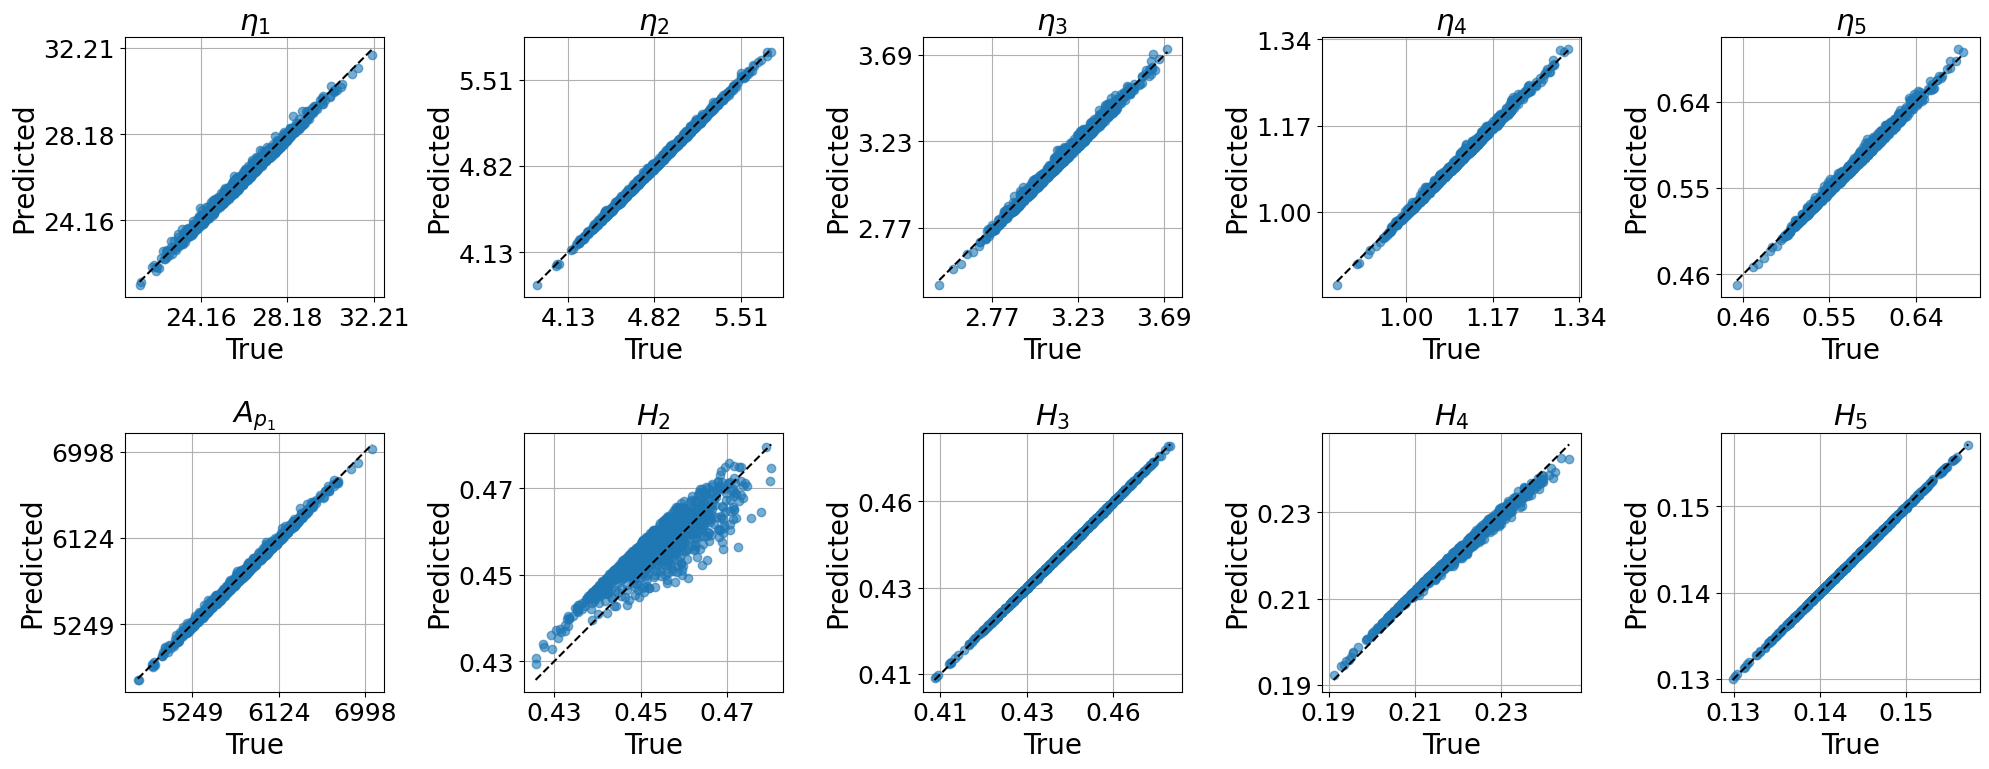

In [47]:
from matplotlib import ticker as mticker



def plot_predictions(true_params, pred_params, param_names=None, ft=16, n_major=3, savefig='figures/figure.pdf'):
    n_params = true_params.shape[1]
    fig, axes = plt.subplots(2, n_params//2, figsize=(2 * n_params, 8))
    axes = axes.flatten()
    
    if param_names is None:
        param_names = [f"$\theta_{i}$" for i in range(n_params)]

    pad_frac = 0.05
    for i in range(n_params):
        vmin = min(true_params[:, i].min(), pred_params[:, i].min())
        vmax = max(true_params[:, i].max(), pred_params[:, i].max())
        rng  = vmax - vmin
        lo   = vmin - pad_frac * rng
        hi   = vmax + pad_frac * rng

        step = (hi-lo) / n_major
        loc  = mticker.MultipleLocator(step)

        ax = axes[i] if n_params > 1 else axes

        if i==5:
            digits = 0                           # show three decimals everywhere
            fmt = mticker.StrMethodFormatter(f'{{x:.{digits}f}}')
            ax.xaxis.set_major_formatter(fmt)
            ax.yaxis.set_major_formatter(fmt)
        else:
            digits = 2                           # show one decimal everywhere
            fmt = mticker.StrMethodFormatter(f'{{x:.{digits}f}}')
            ax.xaxis.set_major_formatter(fmt)
            ax.yaxis.set_major_formatter(fmt)

        ax.plot(true_params[:, i], pred_params[:, i], 'o', alpha=0.6)
        ax.plot([true_params[:, i].min(), true_params[:, i].max()],
                [true_params[:, i].min(), true_params[:, i].max()], 'k--')
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)

                # identical tick lines:
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)
        ax.set_aspect("equal", adjustable="box")  # or set_box_aspect(1)
        ax.set_xlabel(f"True", fontsize=ft)
        ax.set_ylabel(f"Predicted", fontsize=ft)
        ax.tick_params(axis='both', which='major', labelsize=ft-1)
        ax.tick_params(axis='both', which='major', labelsize=ft-2)
        ax.set_title(param_names[i], fontsize=ft+1)
        ax.grid(True)
    
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
peak_param_names = [r'$\eta_1$', r'$\eta_2$', r'$\eta_3$', r'$\eta_4$', r'$\eta_5$',
                    r'$A_{p_1}$', r'$H_2$', r'$H_3$', r'$H_4$', r'$H_5$']
plot_predictions(test_peak_arr, Peaks_pred, peak_param_names, savefig='figures/peak_pred.pdf', ft=20)

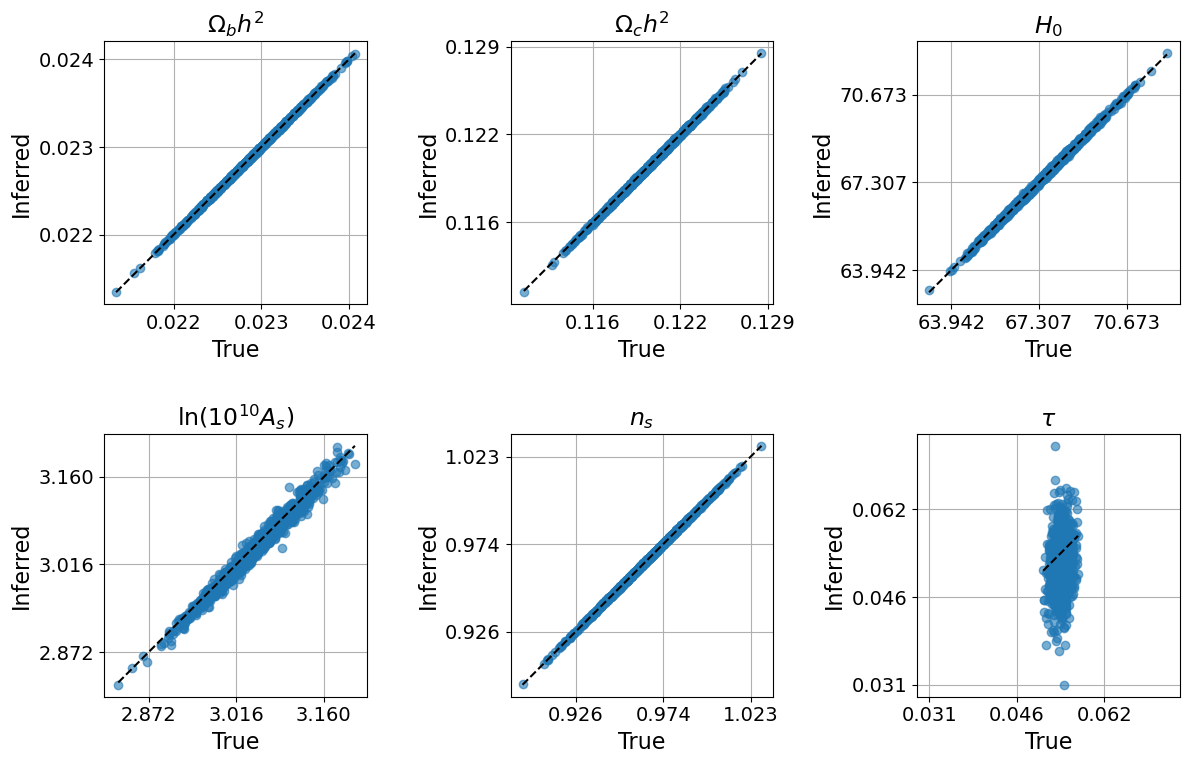

In [48]:
def plot_predictions(true_params, pred_params, param_names=None, ft=16, n_major=3, savefig=None):
    n_params = true_params.shape[1]
    fig, axes = plt.subplots(2, n_params//2, figsize=(2 * n_params, 8))
    axes = axes.flatten()
    
    if param_names is None:
        param_names = [f"$\\theta_{i}$" for i in range(n_params)]

    pad_frac = 0.05
    for i in range(n_params):
        vmin = min(true_params[:, i].min(), pred_params[:, i].min())
        vmax = max(true_params[:, i].max(), pred_params[:, i].max())
        rng  = vmax - vmin
        lo   = vmin - pad_frac * rng
        hi   = vmax + pad_frac * rng

        step = (hi-lo) / n_major
        loc  = mticker.MultipleLocator(step)

        ax = axes[i] if n_params > 1 else axes


        digits = 3                           # show three decimals everywhere
        fmt = mticker.StrMethodFormatter(f'{{x:.{digits}f}}')
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        ax.plot(true_params[:, i], pred_params[:, i], 'o', alpha=0.6)
        ax.plot([true_params[:, i].min(), true_params[:, i].max()],
                [true_params[:, i].min(), true_params[:, i].max()], 'k--')
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)

                # identical tick lines:
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)
        ax.set_aspect("equal", adjustable="box")  # or set_box_aspect(1)
        ax.set_xlabel(f"True", fontsize=ft)
        ax.set_ylabel(f"Inferred", fontsize=ft)
        ax.tick_params(axis='both', which='major', labelsize=ft-1)
        ax.tick_params(axis='both', which='major', labelsize=ft-2)
        ax.set_title(param_names[i], fontsize=ft+1)
        ax.grid(True)
    
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()


plot_predictions(perturbed_LCDM_params, Params_inferred, param_names=param_names, ft=16, savefig='figures/peak_inference.pdf')

In [49]:
peak_pivot_LCDM = PolyCAMB_Peaks.forward_emulator(pivot_LCDM)
peak_pivot_ells, peak_pivot_Dell = peak_pos_hei(peak_pivot_LCDM)

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31505/723546792.py:44: SyntaxWarning: invalid escape sequence '\m'
  ax20.set_ylabel('Res. [$\mu K^2$]', fontsize=ftsize)
/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31505/723546792.py:35: RuntimeWarning: invalid value encountered in divide
  ax10.plot(ells, (pred_pivot_LCDM_Dell[0] - true_pivot_Dell_TT) / true_pivot_Dell_TT * 100, color=color_ls[0])


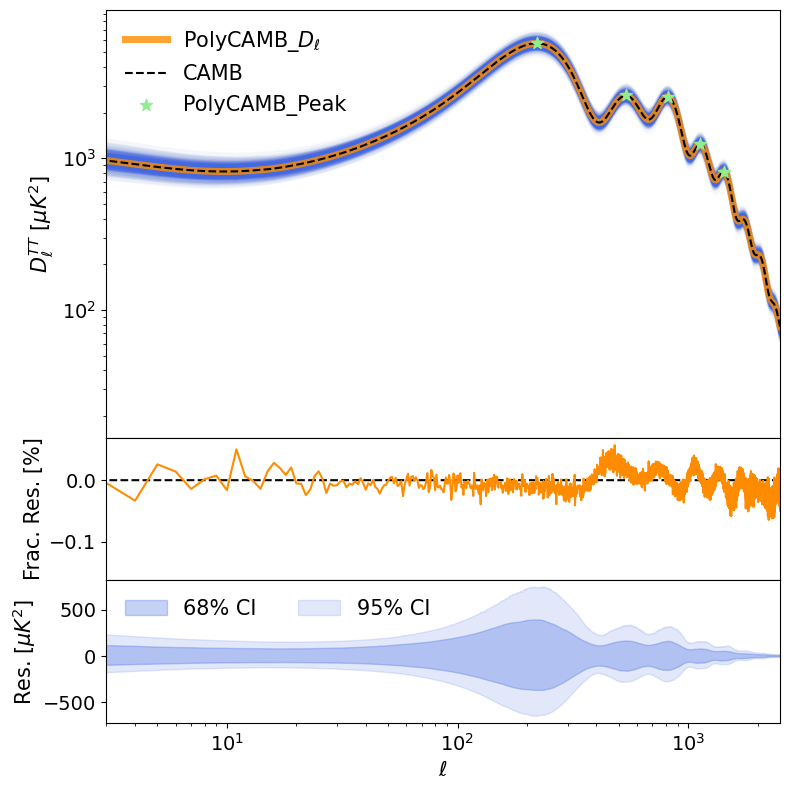

: 

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

color_ls = ['DarkOrange', 'RoyalBlue', 'ForestGreen', 'Crimson', 'Purple', 'Gray']
ftsize = 15

residual_lower_1sigma = np.percentile(pred_perturbed_LCDM_Dell, 16, axis=0) - pred_pivot_LCDM_Dell[0]
residual_upper_1sigma = np.percentile(pred_perturbed_LCDM_Dell, 84, axis=0) - pred_pivot_LCDM_Dell[0]

residual_lower_2sigma = np.percentile(pred_perturbed_LCDM_Dell, 2.5, axis=0) - pred_pivot_LCDM_Dell[0]
residual_upper_2sigma = np.percentile(pred_perturbed_LCDM_Dell, 97.5, axis=0) - pred_pivot_LCDM_Dell[0]

fig = plt.figure(figsize=(8, 8))
gs = GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0.0)

ax00 = fig.add_subplot(gs[0])
for i in range(N_samples):
    ax00.plot(ells, pred_perturbed_LCDM_Dell[i], alpha=0.02,  color=color_ls[1])
ax00.plot(ells, pred_pivot_LCDM_Dell[0], alpha=0.8, lw=5, color=color_ls[0], label=r'PolyCAMB_$D_\ell$')
ax00.plot(ells, true_pivot_Dell_TT, linestyle='--', color='black', label=r'CAMB')
ax00.scatter(peak_pivot_ells, peak_pivot_Dell, color='lightgreen', label=r'PolyCAMB_Peak', marker='*', s=80,zorder=2)
ax00.set_xscale('log')
ax00.set_yscale('log')
#ax00.set_xlabel(r'$\ell$')
ax00.set_xlim(3, 2500)
# ax00.set_ylim(1,8000)
# D_ell is normalised C_ell
#plt.ylabel(r'$C_\ell\ell(\ell+1)/2\pi$')
ax00.set_ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]', fontsize=ftsize)
ax00.legend(loc='upper left', fontsize=ftsize, frameon=False)

ax10 = fig.add_subplot(gs[1], sharex=ax00)
ax10.plot(ells, 0 * ells, color='black', linestyle='--')
ax10.plot(ells, (pred_pivot_LCDM_Dell[0] - true_pivot_Dell_TT) / true_pivot_Dell_TT * 100, color=color_ls[0]) 
ax10.set_xlabel(r'$\ell$', fontsize=ftsize)
ax10.set_ylabel('Frac. Res. [%]', fontsize=ftsize)

ax20 = fig.add_subplot(gs[2], sharex=ax00)
ax20.fill_between(ells, residual_lower_1sigma, residual_upper_1sigma, color=color_ls[1], alpha=0.3, label='68% CI')
ax20.fill_between(ells, residual_lower_2sigma, residual_upper_2sigma, color=color_ls[1], alpha=0.15, label='95% CI')
ax20.legend(frameon=False, fontsize=ftsize, ncol=2)
ax20.set_xlabel(r'$\ell$', fontsize=ftsize)
ax20.set_ylabel('Res. [$\mu K^2$]', fontsize=ftsize)

# Set the fontsize for all tick labels and ticks
for ax in [ax00, ax10, ax20]:
    ax.tick_params(axis='both', which='major', labelsize=ftsize-1)
    ax.tick_params(axis='both', which='minor', labelsize=ftsize-1)
plt.tight_layout()
plt.savefig('figures/poly_camb.pdf', dpi=300)
plt.show()

## Hu01 vs Z25

In [21]:
def peak2_over_peak1(ombh2, omch2, ns):
    om_m = ombh2 + omch2
    numer =  0.925 * om_m ** 0.18 * 2.4 ** (ns-1) 
    denomi = (1 + (ombh2/0.0164)**(12 * om_m**0.52))**0.2
    return numer / denomi

def peak3_over_peak1(ombh2, omch2, ns):
    om_m = ombh2 + omch2
    numer =  2.17 * om_m ** 0.59 * 3.6 ** (ns-1) 
    denomi = (1 + (ombh2/0.044)**2) * ( 1 + 1.63 * (1 - ombh2 / 0.071) * om_m )
    return numer / denomi

In [22]:
length = 100
ombh2_ls = np.linspace(ombh2*0.95, ombh2*1.05, length) 
omch2_ls = np.linspace(omch2*0.9, omch2*1.1, length)
H0_ls = np.linspace(H0*0.85, H0*1.1, length)
ln10As_ls = np.linspace(ln10As*0.96, ln10As*1.06, length)
As_ls = np.exp(ln10As_ls) * 1e-10
ns_ls = np.linspace(ns*0.95, ns*1.01, length)
tau_ls = np.linspace(tau*0.95, tau*1.05, length)

In [23]:
aux_params = np.ones((length,6))
aux_params *= pivot_LCDM[np.newaxis,:]

aux_params_ombh2 = aux_params.copy()
aux_params_ombh2[:,0] = ombh2_ls
aux_params_omch2 = aux_params.copy()
aux_params_omch2[:,1] = omch2_ls
aux_params_H0 = aux_params.copy()
aux_params_H0[:,2] = H0_ls
aux_params_As = aux_params.copy()
aux_params_As[:,3] = ln10As_ls
aux_params_ns = aux_params.copy()
aux_params_ns[:,4] = ns_ls
aux_params_tau = aux_params.copy()
aux_params_tau[:,5] = tau_ls

In [24]:
H2_H01_list = []
H3_H01_list = []

H2_H01_list.append(peak2_over_peak1(ombh2_ls, omch2, ns))
H2_H01_list.append(peak2_over_peak1(ombh2, omch2_ls, ns))
H2_H01_list.append(peak2_over_peak1(ombh2, omch2, ns) * np.ones(length))
H2_H01_list.append(peak2_over_peak1(ombh2, omch2, ns) * np.ones(length))
H2_H01_list.append(peak2_over_peak1(ombh2, omch2, ns_ls) )
H2_H01_list.append(peak2_over_peak1(ombh2, omch2, ns) * np.ones(length))

H3_H01_list.append(peak3_over_peak1(ombh2_ls, omch2, ns))
H3_H01_list.append(peak3_over_peak1(ombh2, omch2_ls, ns))
H3_H01_list.append(peak3_over_peak1(ombh2, omch2, ns) * np.ones(length))
H3_H01_list.append(peak3_over_peak1(ombh2, omch2, ns) * np.ones(length))
H3_H01_list.append(peak3_over_peak1(ombh2, omch2, ns_ls) )
H3_H01_list.append(peak3_over_peak1(ombh2, omch2, ns) * np.ones(length))

In [25]:
def obtain_Z25_H2_H3(aux_params):
    aux = PolyCAMB_Peaks.forward_emulator(aux_params)
    H2 = aux[:, 6]
    H3 = aux[:, 7]
    return H2, H3

H2_Z25_list = []
H3_Z25_list = []

H2, H3 = obtain_Z25_H2_H3(aux_params_ombh2)
H2_Z25_list.append(H2)
H3_Z25_list.append(H3)

H2, H3 = obtain_Z25_H2_H3(aux_params_omch2)
H2_Z25_list.append(H2)
H3_Z25_list.append(H3)

H2, H3 = obtain_Z25_H2_H3(aux_params_H0)
H2_Z25_list.append(H2)
H3_Z25_list.append(H3)

H2, H3 = obtain_Z25_H2_H3(aux_params_As)
H2_Z25_list.append(H2)
H3_Z25_list.append(H3)

H2, H3 = obtain_Z25_H2_H3(aux_params_ns)
H2_Z25_list.append(H2)
H3_Z25_list.append(H3)

H2, H3 = obtain_Z25_H2_H3(aux_params_tau)
H2_Z25_list.append(H2)
H3_Z25_list.append(H3)

In [26]:
def obtain_CAMB_H2_H3(aux_params):
    Dell_list = generate_CAMB_aps(aux_params)
    aux_ells = np.arange(Dell_list.shape[1])
    Peak_list = peak_summary(aux_ells, Dell_list, 5)
    H2 = Peak_list[:, 6]
    H3 = Peak_list[:, 7]
    return H2, H3

H2_CAMB_list = []
H3_CAMB_list = []

H2, H3 = obtain_CAMB_H2_H3(aux_params_ombh2)
H2_CAMB_list.append(H2)
H3_CAMB_list.append(H3)

H2, H3 = obtain_CAMB_H2_H3(aux_params_omch2)
H2_CAMB_list.append(H2)
H3_CAMB_list.append(H3)

H2, H3 = obtain_CAMB_H2_H3(aux_params_H0)
H2_CAMB_list.append(H2)
H3_CAMB_list.append(H3)

H2, H3 = obtain_CAMB_H2_H3(aux_params_As)
H2_CAMB_list.append(H2)
H3_CAMB_list.append(H3)

H2, H3 = obtain_CAMB_H2_H3(aux_params_ns)
H2_CAMB_list.append(H2)
H3_CAMB_list.append(H3)

H2, H3 = obtain_CAMB_H2_H3(aux_params_tau)
H2_CAMB_list.append(H2)
H3_CAMB_list.append(H3)

100%|██████████| 100/100 [00:00<00:00, 28497.79it/s]


/var/folders/r5/jq1d5z7917582lhx9y8r4rj80000gn/T/ipykernel_31505/3221925393.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


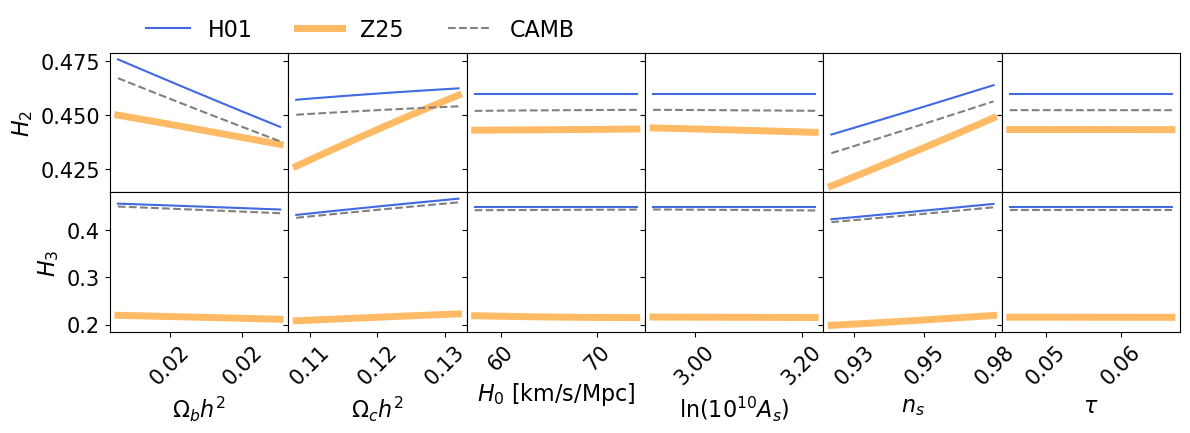

In [27]:

fig, ax = plt.subplots(nrows=2, ncols=6,  
                         figsize=(12, 4),
                         sharey='row', 
                         sharex='col',     
                         gridspec_kw={'wspace': 0.0, 'hspace': 0.0},
                         constrained_layout=True)

xs_list = [ombh2_ls, omch2_ls, H0_ls, ln10As_ls, ns_ls,
        tau_ls ]
xs_labels = [r'$\Omega_b h^2$', r'$\Omega_c h^2$', r'$H_0$ [km/s/Mpc]', r'$\ln(10^{10}A_s)$', r'$n_s$', r'$\tau$']

digits = 2                           # show three decimals everywhere
fmt = mticker.StrMethodFormatter(f'{{x:.{digits}f}}')


ftsize = 16

for i in range(6):
    xs = xs_list[i]
    xs_label = xs_labels[i]
    model_hei2 = H2_H01_list[i]
    pred_hei2 = H2_Z25_list[i]
    model_hei3 = H3_H01_list[i]
    pred_hei3 = H3_Z25_list[i]
    true_h2 = H2_CAMB_list[i]
    true_h3 = H3_CAMB_list[i]

    Emu_line, = ax[0,i].plot(xs, pred_hei2, color=color_ls[0], lw=5, alpha=0.6)
    model_line, = ax[0,i].plot(xs, model_hei2, color=color_ls[1])
    true_line, = ax[0,i].plot(xs, true_h2, color='gray', linestyle='--')
    #ax[0,i].set_xlabel(xs_label)


    #ax[i, 0].set_ylim(5200, 7000)
    ax[1,i].plot(xs, pred_hei3, color=color_ls[0], lw=5, alpha=0.6)
    ax[1,i].plot(xs, model_hei3, color=color_ls[1])
    ax[1,i].plot(xs, true_h3, color='gray', linestyle='--')
    ax[1,i].set_xlabel(xs_label, fontsize=ftsize)
    ax[1,i].tick_params(axis='x', rotation=45)
    if i!=2:
        ax[1,i].xaxis.set_major_formatter(fmt)
    if i==0:
        ax[0,i].set_ylabel(r'$H_2$', fontsize=ftsize)
        ax[1,i].set_ylabel(r'$H_3$', fontsize=ftsize)

    ax[0,i].tick_params(axis='both', which='major', labelsize=ftsize-1)
    ax[0,i].tick_params(axis='both', which='minor', labelsize=ftsize-2)
    ax[1,i].tick_params(axis='both', which='major', labelsize=ftsize-1)
    ax[1,i].tick_params(axis='both', which='minor', labelsize=ftsize-2)
# Create figure-level legend
fig.legend(
    [model_line, Emu_line, true_line],  # Handles from your plots
    ['H01', 'Z25', 'CAMB'],  # Labels
    ncol=3,                # Number of columns
    loc='upper right',        # Anchor point position
    bbox_to_anchor=(0.5, 1.1),  # Position in figure coordinates
    bbox_transform=fig.transFigure , # Use figure coordinate system
    fontsize=ftsize,
    frameon=False
)

plt.tight_layout()
plt.savefig('figures/H2_H3.pdf', bbox_inches='tight')
plt.show()


    

In [28]:
from sklearn.metrics import mean_squared_error
H2_CAMB_list = np.array(H2_CAMB_list)
H3_CAMB_list = np.array(H3_CAMB_list)
H2_Z25_list = np.array(H2_Z25_list)
H3_Z25_list = np.array(H3_Z25_list)
H2_H01_list = np.array(H2_H01_list)
H3_H01_list = np.array(H3_H01_list)
print("RMSfE of H2_Z25:", np.sqrt(np.mean(( H2_Z25_list /H2_CAMB_list - 1. )**2)))
print("RMSfE of H3_Z25:", np.sqrt(mean_squared_error( H3_Z25_list/H3_CAMB_list, np.ones_like(H3_CAMB_list) )))

print("RMSfE of H2_H01:", np.sqrt(mean_squared_error( H2_H01_list/H2_CAMB_list, np.ones_like(H2_CAMB_list) )))
print("RMSfE of H3_H01:", np.sqrt(mean_squared_error( H3_H01_list/H3_CAMB_list, np.ones_like(H3_CAMB_list) )))


RMSfE of H2_Z25: 0.023001432166933275
RMSfE of H3_Z25: 0.5139872738594709
RMSfE of H2_H01: 0.017284844944621403
RMSfE of H3_H01: 0.01596543117169932


## Symbolic analysis

In [29]:
import math
from itertools import product
import sympy as sp


def taylor_multivariate(expr, vars_, point, order=2):
    series = 0
    subs0 = dict(zip(vars_, point))

    for powers in product(range(order + 1), repeat=len(vars_)):
        if sum(powers) > order:
            continue

        term = expr
        denom = 1
        for v, k in zip(vars_, powers):
            if k:
                term = sp.diff(term, v, k)
                denom *= math.factorial(k)
        term = term.subs(subs0) / denom

        for v, k, p0 in zip(vars_, powers, point):
            if k:
                term *= (v - p0) ** k

        series += term

    return sp.expand(series)

def peak2_over_peak1_expr():
    ombh2, omch2, ns = sp.symbols('ombh2 omch2 ns')
    om_m = ombh2 + omch2
    expr = (
        0.925 * om_m ** sp.Rational(18, 100) * 2.4 ** (ns - 1)
        / (1 + (ombh2 / 0.0164) ** (12 * om_m ** sp.Rational(52, 100))) ** sp.Rational(1, 5)
    )
    return expr, (ombh2, omch2, ns)

def peak3_over_peak1_expr():
    """
    Return a SymPy expression for the empirical third-to-first-acoustic-peak
    height ratio, together with its symbol tuple (ombh2, omch2, ns).

    H₃ / H₁  ≡  2.17 · Ωₘ⁰·⁵⁹ · 3.6^(n_s – 1)
                ───────────────────────────────────
                (1 + (Ω_bh² / 0.044)²) · (1 + 1.63·(1 − Ω_bh²/0.071)·Ωₘ)
    """
    # define symbols
    ombh2, omch2, ns = sp.symbols('ombh2 omch2 ns')

    # shorthand
    om_m = ombh2 + omch2

    # build the expression
    expr = (
        2.17 * om_m**sp.Rational(59, 100) * 3.6**(ns - 1)
        / (
            (1 + (ombh2 / 0.044)**2)
            * (1 + 1.63 * (1 - ombh2 / 0.071) * om_m)
        )
    )

    return expr, (ombh2, omch2, ns)


def peak2_over_peak1_taylor(point, order=2):
    expr, vars_ = peak2_over_peak1_expr()
    return taylor_multivariate(expr, vars_, point, order)

def peak3_over_peak1_taylor(point, order=2):
    expr, vars_ = peak3_over_peak1_expr()
    return taylor_multivariate(expr, vars_, point, order)




In [30]:
# Symbolic expressions for the peak observables 
forward_expressions = PolyCAMB_Peaks.generate_forward_symb_emu()

In [31]:
from sympy import latex

In [32]:
aux = PolyCAMB_Peaks.scaler_X.mean_
H2_model_taylor_series = peak2_over_peak1_taylor((aux[0], aux[1], aux[4]), order=2)
latex(H2_model_taylor_series)

'0.176083343050494 ns^{2} - 12.2193240676206 ns ombh_{2} + 0.215857622611722 ns omch_{2} + 0.31058470461607 ns + 160.473306087862 ombh_{2}^{2} - 77.3123335315927 ombh_{2} omch_{2} - 0.133201570643822 ombh_{2} - 1.58887706852276 omch_{2}^{2} + 2.1233517084386 omch_{2} + 0.133683794443168'

In [33]:
from sympy import latex
print("H_2 expression generated by MomentEmu:")
latex(forward_expressions[6])

H_2 expression generated by MomentEmu:


'- 74.8360006733827 x_{1}^{2} - 16.0101641805949 x_{1} x_{2} - 0.0148642630837388 x_{1} x_{3} + 0.0400882962679291 x_{1} x_{4} - 4.11996030955399 x_{1} x_{5} - 3.34897672865456 x_{1} x_{6} + 4.25091353116231 x_{1} - 3.71250072148035 x_{2}^{2} - 0.000256755000783651 x_{2} x_{3} - 0.0699243696005484 x_{2} x_{4} + 1.58285796238873 x_{2} x_{5} - 0.226375990728175 x_{2} x_{6} + 1.33894938609877 x_{2} + 8.05260647604805 \\cdot 10^{-7} x_{3}^{2} + 5.46234016687071 \\cdot 10^{-5} x_{3} x_{4} - 0.000354727666589196 x_{3} x_{5} + 0.000678499878297076 x_{3} x_{6} + 0.00042892423940261 x_{3} - 0.00284526831667918 x_{4}^{2} - 0.00455303051147118 x_{4} x_{5} + 0.00106392889102495 x_{4} x_{6} + 0.0188507943125372 x_{4} + 0.338054974198598 x_{5}^{2} - 0.113927788024831 x_{5} x_{6} - 0.146881028868974 x_{5} + 0.0652068511072498 x_{6}^{2} + 0.142608046145927 x_{6} + 0.0639041233190951'

In [34]:
print("H_3 expression generated by MomentEmu:")
latex(forward_expressions[7])

H_3 expression generated by MomentEmu:


'- 64.7065480856477 x_{1}^{2} - 14.6687921246112 x_{1} x_{2} - 0.0239671980493975 x_{1} x_{3} + 0.00074252938379497 x_{1} x_{4} - 1.36695865515886 x_{1} x_{5} - 5.74496650378985 x_{1} x_{6} + 4.15610171355731 x_{1} - 1.50858286343894 x_{2}^{2} - 0.00521828755018966 x_{2} x_{3} - 0.0217636445746119 x_{2} x_{4} + 1.68270997960028 x_{2} x_{5} - 1.35159147889807 x_{2} x_{6} + 0.165131493523108 x_{2} + 1.16304593129379 \\cdot 10^{-5} x_{3}^{2} + 2.07189205014179 \\cdot 10^{-5} x_{3} x_{4} - 0.0030326720834527 x_{3} x_{5} + 0.00450986037514026 x_{3} x_{6} + 0.00201245063119077 x_{3} - 0.000660712454194005 x_{4}^{2} - 0.00381365319640946 x_{4} x_{5} + 0.00239830058320056 x_{4} x_{6} + 0.00549237972416287 x_{4} + 0.576732233508395 x_{5}^{2} - 0.776996773473861 x_{5} x_{6} - 0.642201622553837 x_{5} + 0.727595808285505 x_{6}^{2} + 0.583644417543315 x_{6} + 0.210832358459014'

In [35]:
aux = PolyCAMB_Peaks.scaler_X.mean_
H3_model_taylor_series = peak3_over_peak1_taylor((aux[0], aux[1], aux[4]), order=2)
latex(H3_model_taylor_series)

'0.364112821767639 ns^{2} - 6.92672229820266 ns ombh_{2} + 1.81111059443377 ns omch_{2} - 0.188233142283377 ns - 74.080079188007 ombh_{2}^{2} - 22.2249543556735 ombh_{2} omch_{2} + 7.09834436076494 ombh_{2} - 4.03487179659943 omch_{2}^{2} + 1.15036156029791 omch_{2} + 0.0907729716642885'

In [36]:
expr, _ = peak2_over_peak1_expr()
latex(expr)

'\\frac{0.925 {2.4}^{ns - 1} \\left(ombh_{2} + omch_{2}\\right)^{\\frac{9}{50}}}{\\sqrt[5]{\\left(60.9756097560976 ombh_{2}\\right)^{12 \\left(ombh_{2} + omch_{2}\\right)^{\\frac{13}{25}}} + 1}}'

In [37]:
%timeit aux = PolyCAMB_Dl.forward_emulator(pivot_LCDM)
# 10 ms / 1000 ==> 10 μs a call

5.12 ms ± 31.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%timeit aux = PolyCAMB_Peaks.forward_emulator(pivot_LCDM)

98.2 μs ± 323 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## COBAYA

In [39]:
import pickle

# Suppose `emu` is your trained emulator object, e.g.
# emu = MomentEmu(...) followed by emu.fit(...)

with open("PolyCAMB_Dl_N6.pkl", "wb") as f:
    pickle.dump(PolyCAMB_Dl, f)

In [40]:
with open("PolyCAMB_peak_N6.pkl", "wb") as f:
    pickle.dump(PolyCAMB_Peaks, f)
